# PROJETO - PREVISÃO DE PREÇO DE CASAS

## Sumário

### 1. Resumo Executivo
- 1.1 Visão Geral do Projeto 
- 1.2 Insights e Conclusões
- 1.3 Impacto Esperado

### 2. Introdução
- 2.1 Contexto do Problema
- 2.2 Motivação para o Estudo
- 2.3 Relevância do Tema no Mercado
- 2.4 Objetivos do Estudo

### 3. Metodologia
- 3.1 Descrição do Conjunto de Dados
- 3.2 Técnicas Escolhidas para o Processamento
- 3.3 Métodos Escolhidos para Modelagem Preditiva
- 3.4 Críterios de Avaliação

### 4. Análise Exploratória de Dados
- 4.1 Descrição das Variáveis do Dataset
- 4.2 Verificando valores nulos
- 4.3 Mapa Calor - Correlação Geral das Variáveis
- 4.4 Mapa Calor - 10 Variáveis mais Correlacionadas com o Target (SalePrice)
- 4.5 Conclusão

### 5. Engenharia de Atributos

- 5.1 Identificação e Tratamento de Outliers
- 5.1.1 Detecção de Outliers: Métodos de Z-Score e IQR
- 5.1.2 Resultado da Análise
- 5.1.2.1 Variáveis e Manter os Outliers
- 5.1.2.2 Remoção de Casos Extremos
- 5.1.3 Conclusão

- 5.2 Análise de Distribuição das Variáveis
- 5.2.1 Padronização das Variáveis
- 5.2.3 Conclusão

- 5.3 Preparação Final dos Dados para o Modelo de Regressão
- 5.3.1 Separação entre as Variáveis Preditivas e Variável Alvo
- 5.3.2 Divisão entre Treino e teste

- 5.4 Conclusão da Engenharia de Atributos

### 6. Treinamento e Avaliação
- 6.1 Treinamento
- 6.2 Avaliação 
- 6.3 Conclusão
6.4 Comparação de Resultados Previstos e Reais


### 7. Conclusão

### Importação de bibliotecas

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

### Lendo os Datasets

In [ ]:
df = pd.read_csv('data/train.csv')

## Resumo Executivo

### 1. Visão Geral do Projeto
O presente estudo tem como objetivo desenvolver um modelo preditivo para estimar o preço de venda de imóveis com base em suas características estruturais e localização. A análise é realizada utilizando um conjunto de dados contendo diversas variáveis que influenciam o valor dos imóveis, como metragem, qualidade da construção, número de cômodos e ano de construção.

A metodologia empregada abrange desde a exploração inicial dos dados até a construção e avaliação de modelos de Machine Learning. O objetivo é identificar os principais fatores que impactam os preços dos imóveis e fornecer um modelo preciso para auxiliar na precificação de propriedades.

### 2. Insights e Conclusões
Durante o desenvolvimento deste projeto, foi possível observar que a qualidade da construção e a metragem dos imóveis são dois dos fatores mais influentes na determinação do preço, seguidos pela localização e pelo ano de construção. Embora o modelo de regressão linear tenha mostrado uma boa capacidade de previsão, com um R² de 0,80, foi identificado que a presença de outliers e a distribuição desigual de algumas variáveis podem ter afetado a precisão das previsões, como evidenciado pelo elevado valor do RMSE. O MAE, de aproximadamente 22 mil, indicou que o modelo estava, em média, cometendo erros aceitáveis para o contexto do mercado imobiliário, onde os preços das casas variam significativamente. No entanto, melhorias são necessárias, especialmente na limpeza dos dados e no tratamento de outliers, para refinar o modelo e garantir uma maior precisão nas previsões. Em uma versão futura, a normalização dos dados e a investigação mais detalhada de fatores não considerados inicialmente, como características específicas do bairro, podem resultar em um desempenho ainda melhor.

### 3. Impacto Esperado
A implementação de um modelo preditivo para a precificação de imóveis pode trazer diversas vantagens, como:

- **Tomada de decisão mais assertiva**: compradores, vendedores e imobiliárias poderão definir preços com base em análises objetivas, reduzindo incertezas.

- **Eficiência na avaliação de propriedades**: automação da precificação pode reduzir o tempo e custo necessário para estimar valores de mercado.

- **Melhoria na transparência do mercado imobiliário**: dados mais precisos ajudam a evitar superavaliações ou subavaliações.

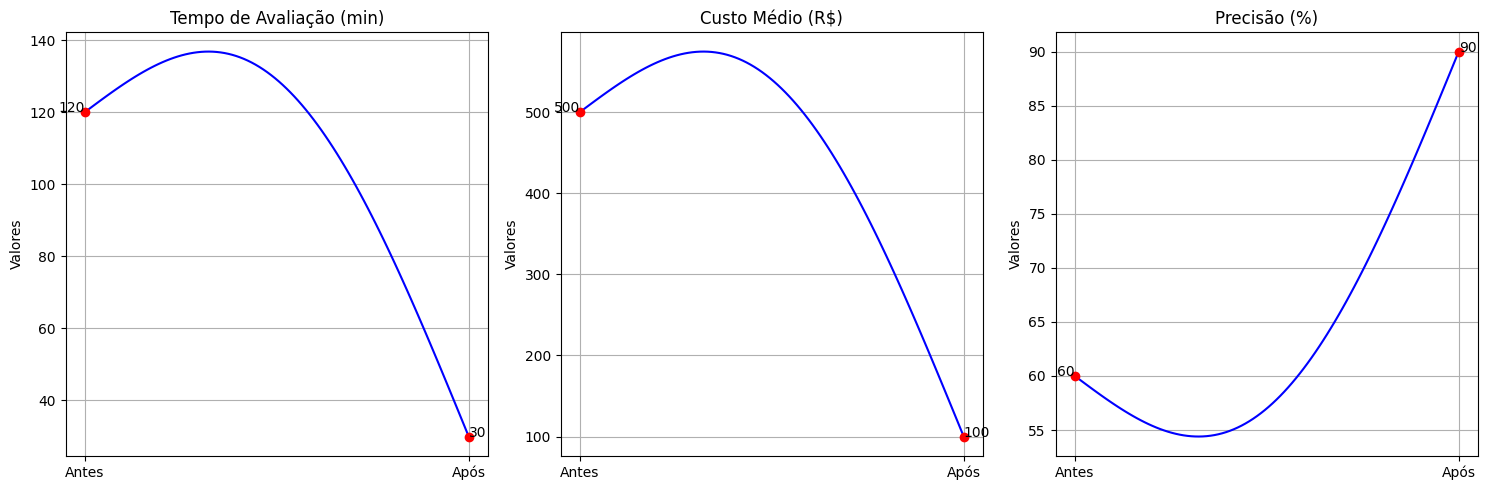

In [6]:
# Definição das categorias e valores
categorias = ['Tempo de Avaliação (min)', 'Custo Médio (R$)', 'Precisão (%)']
antes = [120, 500, 60]  # Valores antes da implementação
apos = [30, 100, 90]  # Valores após a implementação

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Criando 3 gráficos lado a lado

graficos = zip(axes, categorias, antes, apos)

for ax, categoria, valor_antes, valor_apos in graficos:
    x = np.linspace(0, 1, 100)
    curva = np.interp(x, [0, 1], [valor_antes, valor_apos]) + np.sin(x * np.pi) * (valor_antes - valor_apos) * 0.6
    
    ax.plot(x, curva, linestyle='-', color='blue')
    ax.scatter([0, 1], [valor_antes, valor_apos], color='red', zorder=3)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Antes', 'Após'])
    ax.set_title(categoria)
    ax.set_ylabel('Valores')
    ax.grid(True)
    ax.text(0, valor_antes, str(valor_antes), ha='right', fontsize=10)
    ax.text(1, valor_apos, str(valor_apos), ha='left', fontsize=10)

plt.tight_layout()
plt.show()

> Nota - Os gráficos apresentados são apenas um mock para demonstrar a ideia visual. Os valores podem não refletir dados reais.

## Introdução

### 1. Contexto do Problema
O mercado imobiliário é influenciado por uma série de variáveis que impactam diretamente o valor de um imóvel, como localização, metragem, qualidade da construção e demanda do mercado. No entanto, a precificação muitas vezes é feita de forma subjetiva, resultando em avaliações inconsistentes e, em alguns casos, equivocadas. Esse cenário cria desafios tanto para compradores quanto para vendedores, dificultando a negociação e reduzindo a eficiência das transações.

### 2. Motivação para o Estudo
Com o avanço da tecnologia e o crescente volume de dados disponíveis, tornou-se possível utilizar abordagens baseadas em Machine Learning para prever preços de imóveis com maior precisão. Esse estudo busca explorar o uso de técnicas preditivas para minimizar erros na avaliação e criar um modelo que auxilie na tomada de decisão de compradores, vendedores e agentes imobiliários.

### 3. Relevância do Tema no Mercado
A correta precificação de imóveis é essencial para um mercado imobiliário mais transparente e eficiente. Um modelo preditivo confiável pode beneficiar não apenas indivíduos e empresas do setor imobiliário, mas também instituições financeiras que utilizam a avaliação de imóveis para concessão de crédito e financiamento. Além disso, a automação da precificação pode reduzir o tempo e os custos envolvidos no processo.

### 4. Objetivos do Estudo
Este estudo tem como objetivo desenvolver um modelo de Machine Learning capaz de prever o preço de imóveis com base em suas características estruturais e de localização. Além disso, o estudo buscará identificar e qualificar as características que mais impactam no valor de um imóvel, permitindo uma compreensão mais aprofundada dos fatores que determinam a precificação no mercado imobiliário. Para isso, serão realizadas etapas de exploração de dados, engenharia de variáveis, seleção de modelos e avaliação de desempenho, visando criar uma ferramenta que possa ser utilizada para auxiliar na precificação de propriedades de forma objetiva e precisa.

## Metodologia

Este capítulo aborda a explicação das escolhas metodológicas, incluindo as técnicas utilizadas no processamento dos dados, os modelos preditivos adotados e os critérios para avaliação do desempenho.

### 1. Descrição do Conjunto de Dados

O conjunto de dados escolhido para este estudo foi o disponibilizado no Kaggle "House Prices - Advanced Regression Techniques". Esse dataset contém informações sobre imóveis e suas características estruturais, geográficas e temporais. As variáveis incluem atributos como metragem, número de quartos, número de banheiros, localização, ano de construção, entre outros.

### 2. Técnicas Escolhidas para o Processamento

Para garantir a qualidade dos dados e a eficiência do modelo, foram aplicadas as seguintes técnicas de processamento:

- **Tratamento de valores ausentes**: Métodos como imputação por média/mediana e remoção de registros incompletos foram avaliados.

- **Detecção e remoção de outliers**: Análise de dispersão e técnicas estatísticas (z-score, IQR) foram utilizadas para lidar com valores atípicos.

- **Normalização e padronização**: Variáveis contínuas foram escalonadas utilizando Min-Max Scaling ou StandardScaler, conforme a necessidade do modelo.

- **Codificação de variáveis categóricas**: Métodos como One-Hot Encoding e Label Encoding foram aplicados para transformar variáveis categóricas em um formato adequado para os modelos de Machine Learning.

### 3. Métodos Escolhidos para Modelagem Preditiva

Para a modelagem preditiva, foi escolhida a Regressão Linear, uma abordagem estatística amplamente utilizada para prever valores contínuos com base em variáveis explicativas. A escolha dessa técnica se deve a vários benefícios, incluindo:

- **Interpretação simples**: Permite entender o impacto de cada variável independente sobre o preço dos imóveis.

- **Eficiência computacional**: Modelos de regressão linear são rápidos de treinar e exigem menos recursos computacionais em comparação com técnicas mais complexas.

- **Relação linear entre variáveis**: Útil para capturar tendências gerais no conjunto de dados e fornecer um ponto de partida sólido para a análise preditiva.

- **Generalização**: Quando bem ajustada, a regressão linear pode apresentar bons resultados sem superajustar aos dados de treinamento.


### 4. Critérios de Avaliação
Para comparar o desempenho dos modelos, foram utilizadas métricas comuns em problemas de regressão:

- **Erro Quadrático Médio (MSE)**: Mede a média dos erros ao quadrado, penalizando grandes discrepâncias.

- **Erro Médio Absoluto (MAE)**: Mede a média dos erros absolutos, fornecendo uma interpretação mais intuitiva dos desvios.

- **Coeficiente de Determinação (R²)**: Mede o quão bem o modelo explica a variabilidade dos dados.

##  Análise Exploratória de Dados (EDA)

Essa etapa tem como objetivo entender melhor o conjunto de dados, identificar padrões, detectar inconsistências e selecionar variáveis relevantes para a modelagem. Neste estudo, a EDA será composta pelas seguintes etapas: descrição das variáveis para avaliar sua distribuição e impacto sobre o preço dos imóveis, verificação da presença de valores ausentes e definição de estratégias para tratá-los, construção de um mapa de calor geral para analisar a correlação entre todas as variáveis, escolha de 10 variáveis principais mais relevantes para a previsão do preço, seguida da criação de um mapa de calor restrito a essas variáveis para aprofundar a compreensão das relações entre elas. Essas análises permitirão otimizar a escolha das características mais impactantes na modelagem preditiva.

### 1. Descrição das Variáveis do Dataset:
A seguir, uma lista das variáveis presentes no dataset com seus respectivos valores e descrições:

In [7]:
with open('data_description.txt', 'r', encoding='utf-8') as file:
    variaveis = file.read()

print(variaveis)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### 2. Verificando valores nulos:

In [8]:
df.isnull().sum()[df.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

---
Durante a análise do conjunto de dados, das variáveis que apresentavam valores nulos foi possível identificar apenas duas que precisavam de correção.

In [9]:
df['LotFrontage'] = df['LotFrontage'].fillna(0)
df['Electrical'] = df['Electrical'].fillna('SBrkr')

**LotFrontage**: que representa a largura da frente do lote, apresentou valores ausentes (NaN). Como é uma variável numérica e, após análise, concluímos que a substituição por um valor fixo seria a melhor abordagem, optei por substituir os valores nulos por 0, considerando que a ausência de informações sobre a largura da frente do lote pode ser tratada como a ausência de lote.

**Electrical**: Esta variável, que representa o tipo de sistema elétrico da casa, também apresentou valores ausentes. Para variáveis categóricas como esta, a melhor prática é substituir os valores nulos pelo valor mais frequente da coluna, ou seja, a moda. Nesse caso, a moda foi "SBrkr" (que se refere ao sistema elétrico "Standard Circuit Breaker Panel"), portanto, todos os valores nulos nesta coluna foram substituídos por "SBrkr".

O próximo passo após a correção dos valores nulos e a análise das distribuições das variáveis e a detecção de outliers.

### 3. Mapa de Calor - Correlação Geral das Variáveis
Nesta etapa, foi gerado um mapa de calor (heatmap) para visualizar a correlação entre todas as variáveis numéricas do conjunto de dados. O objetivo deste gráfico é identificar como cada variável se relaciona com as demais, além de observar possíveis padrões e variáveis altamente correlacionadas. Esta visão geral ajuda na detecção de colinearidade e fornece um panorama completo da estrutura do dataset.

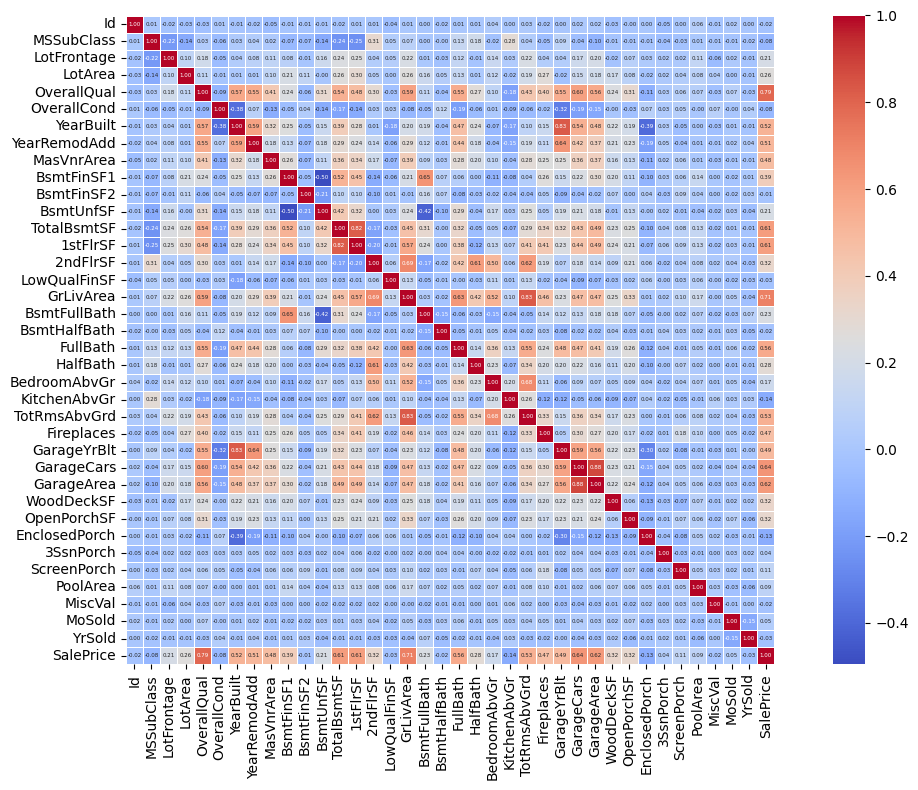

In [10]:
num_df = df.select_dtypes(include=['float64', 'int64'])

# Calcula a matriz de correlação
corr = num_df.corr()

# Faz o heatmap
plt.figure(figsize=(12, 8))  
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 4}, linewidths=0.5, square=True)

# Exibindo o gráfico
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

### 4. Mapa de Calor - 10 Variáveis mais Correlacionadas com o target (SalePrice)
Após a análise geral, foi realizada uma filtragem para selecionar as 10 variáveis mais correlacionadas com a variável alvo SalePrice. Esse segundo heatmap apresenta a correlação entre essas variáveis e o SalePrice, além das correlações entre elas mesmas. O objetivo é destacar os principais fatores que possuem maior impacto no preço de venda das casas, auxiliando na seleção de variáveis mais relevantes para a construção dos modelos preditivos.

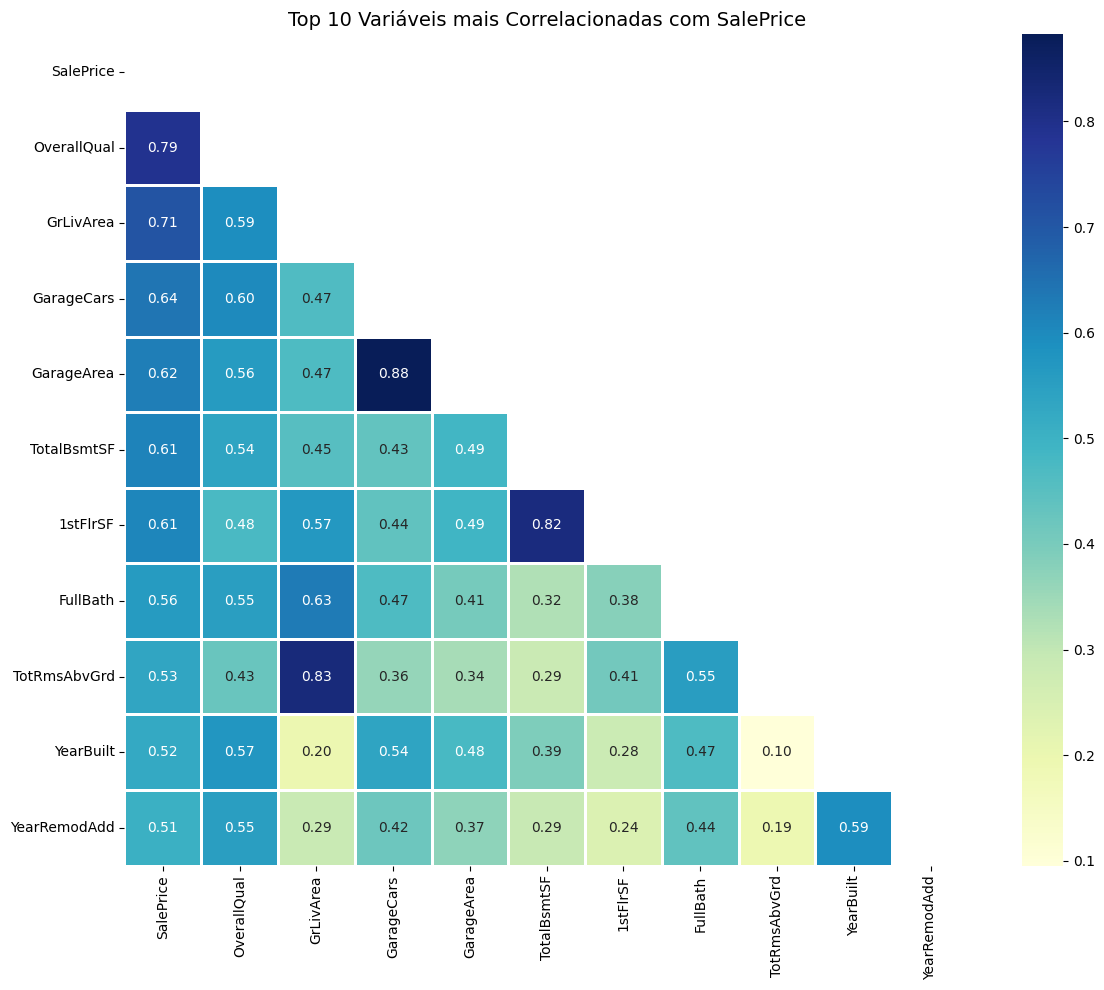

In [11]:
# Seleciona as 10 variáveis mais correlacionadas e o SalePrice
target_corr = corr['SalePrice'].abs().sort_values(ascending=False)
top_corr_vars = target_corr.index[:11]  

# Filtra a matriz de correlação só para as variáveis selecionadas
corr_top = corr.loc[top_corr_vars, top_corr_vars]

# Máscara para exibir apenas o triângulo inferior
mask = np.triu(np.ones_like(corr_top, dtype=bool))

# Cria o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_top, 
    mask=mask,               # Mostra só o triângulo inferior
    annot=True,              # Mostra os valores nas células
    fmt=".2f",               # Formato das anotações
    cmap='YlGnBu',           # Paleta de cores
    linewidths=1,            # Linhas entre as células
    linecolor='white',       
    annot_kws={"size": 10}   # Tamanho do texto das anotações
)

# Título do gráfico
plt.title('Top 10 Variáveis mais Correlacionadas com SalePrice', fontsize=14)

# Ajusta o layout
plt.tight_layout()

# Exibe o gráfico
plt.show()

#### **Conclusão do EDA**

Durante a etapa de Análise Exploratória de Dados (EDA), realizamos uma série de atividades para entender as características e distribuições dos dados, identificar potenciais problemas como valores ausentes, explorar as variáveis mais relevantes para a previsão do preço de venda das casas.

Primeiramente, fizemos uma tratativa de valores ausentes, depois realizamos uma análise de correlação entre as variáveis e a variável alvo **SalePrice**, identificando as que mais influenciam o preço.

Após essa análise, selecionamos as variáveis mais impactantes, aquelas que apresentam maior correlação com o **SalePrice** e que têm um impacto significativo no preço das casas. As variáveis escolhidas para continuar a análise foram:

- **OverallQual** (qualidade geral da casa)
- **GrLivArea** (área total da sala de estar)
- **GarageCars** (número de carros que a garagem pode acomodar)
- **GarageArea** (área da garagem)
- **TotalBsmtSF** (área total do porão)
- **1stFlrSF** (área do primeiro andar)
- **TotRmsAbvGrd** (número total de quartos acima do solo)
- **YearBuilt** (ano de construção)
- **YearRemodAdd** (ano de renovação)
- **FullBath** (número de banheiros completos)

Essas variáveis foram selecionadas com base nas correlações identificadas, com o objetivo de construir um modelo de previsão do preço de venda das casas. O próximo passo será realizar o pré-processamento, que inclui o tratamento de valores ausentes, a normalização e/ou padronização das variáveis, e o treinamento do modelo, onde testaremos técnicas de Machine Learning para prever com precisão os preços das casas.

In [12]:
# Selecionando as variáveis desejadas
selected_columns = [
    'OverallQual',  
    'GrLivArea',    
    'GarageCars',   
    'GarageArea',   
    'TotalBsmtSF',  
    '1stFlrSF',     
    'TotRmsAbvGrd', 
    'YearBuilt',    
    'YearRemodAdd', 
    'FullBath'      
]

# Criando o novo DataFrame com as colunas selecionadas
df_selected = df[selected_columns + ['SalePrice'] ]

## Engenharia de Atributos 

Agora, na Engenharia de Atributos, iremos transformar e criar variáveis para otimizar a performance do modelo preditivo. Essa etapa é essencial porque, muitas vezes, os dados brutos não possuem a melhor representação para que o algoritmo consiga identificar padrões de forma eficiente.

### 1. Identificação e Tratamento de Outliers
Primeiramente, realizamos o tratamento de outliers nas variáveis selecionadas com maior correlação com o preço de venda (SalePrice). Outliers podem distorcer os resultados da Regressão Linear, impactando negativamente o desempenho do modelo. O tratamento pode incluir a remoção de registros extremos ou a aplicação de transformações como o logaritmo.

#### 1.1 Detecção de Outliers: Métodos de Z-Score e IQR
Para identificar os outliers nos dados, foram escolhidos dois métodos estatísticos: Z-score e IQR (Interquartile Range). O Z-score mede quantos desvios padrão um valor está distante da média, permitindo identificar pontos que se desviam significativamente da distribuição normal dos dados. Já o IQR, baseado nos quartis, define como outliers os valores que estão além de 1.5 vezes o intervalo interquartil, sendo uma abordagem mais robusta para distribuições assimétricas.

In [13]:
def identificar_outliers(df, coluna, metodo='iqr', limite_z=3):
    """
    Identifica outliers em uma coluna numérica de um DataFrame.
    
    Parâmetros:
    - df: DataFrame pandas contendo os dados
    - coluna: Nome da coluna a ser analisada
    - metodo: Método para detecção de outliers ('iqr' ou 'zscore')
    - limite_z: Limite do Z-score para considerar um valor como outlier (padrão: 3)
    
    Retorna:
    - DataFrame com os outliers identificados
    """
    valores = df[coluna]
    
    if metodo == 'iqr':
        # Cálculo do IQR
        Q1 = valores.quantile(0.25)
        Q3 = valores.quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        outliers = df[(valores < limite_inferior) | (valores > limite_superior)]
    
    elif metodo == 'zscore':
        # Cálculo do Z-score
        media = valores.mean()
        desvio_padrao = valores.std()
        z_scores = (valores - media) / desvio_padrao
        outliers = df[np.abs(z_scores) > limite_z]

    else:
        raise ValueError("Método inválido! Escolha 'iqr' ou 'zscore'.")

    return outliers

In [14]:
# Criar um dicionário para armazenar a quantidade de outliers por método
outliers_count = {"Coluna": [], "Outliers (IQR)": [], "Outliers (Z-score)": []}

# Identificar outliers para cada coluna e armazenar os resultados
for coluna in df_selected:
    outliers_iqr = identificar_outliers(df_selected, coluna, metodo='iqr')
    outliers_zscore = identificar_outliers(df_selected, coluna, metodo='zscore')

    outliers_count["Coluna"].append(coluna)
    outliers_count["Outliers (IQR)"].append(len(outliers_iqr))
    outliers_count["Outliers (Z-score)"].append(len(outliers_zscore))

# Criar um DataFrame com os resultados
outliers_df = pd.DataFrame(outliers_count)

# Exibir a tabela formatada
display(outliers_df.style.set_table_styles([{"selector": "th", "props": [("font-weight", "bold")]}]))

,Coluna,Outliers (IQR),Outliers (Z-score)
0,OverallQual,2,2
1,GrLivArea,31,16
2,GarageCars,5,0
3,GarageArea,21,7
4,TotalBsmtSF,61,10
5,1stFlrSF,20,12
6,TotRmsAbvGrd,30,12
7,YearBuilt,7,6
8,YearRemodAdd,0,0
9,FullBath,0,0


#### 1.2 Resultado da Análise  
Após a detecção de outliers, foi realizada uma avaliação dos impactos desses valores extremos na modelagem preditiva. A decisão sobre o tratamento dos outliers foi baseada na relevância de cada variável para a previsão do preço dos imóveis e no risco de distorção dos resultados caso esses valores fossem mantidos sem ajustes.  

##### 1.2.1 Variáveis a Manter os Outliers  
Algumas variáveis apresentaram um número reduzido de outliers ou possuem características que justificam a presença de valores extremos, sem representar erros de medição ou distorções significativas. Essas variáveis são:  

- **OverallQual (Qualidade geral da casa)**: Outliers representam imóveis de qualidade excepcional ou muito baixa, sendo informações valiosas para o modelo.  
- **GarageCars (Número de carros na garagem)**: Pequena variação nos outliers, refletindo diferenças reais na infraestrutura dos imóveis.  
- **YearBuilt (Ano de construção)**: Outliers indicam casas muito antigas ou muito novas, sendo uma informação crucial na precificação.  


##### 1.2.2 Remoção de Casos Extremos  
Os valores extremamente discrepantes foram analisados e, para evitar que distorçam a modelagem, serão removidos do conjunto de dados. No total, **125 casos serão excluídos**, correspondentes a registros com outliers significativos nas seguintes variáveis:  

- **GrLivArea (Área total da sala de estar)**: 31 casos  
- **GarageArea (Área da garagem)**: 21 casos  
- **TotalBsmtSF (Área total do porão)**: 61 casos  
- **1stFlrSF (Área do primeiro andar)**: 20 casos  
- **TotRmsAbvGrd (Número total de quartos acima do solo)**: 30 casos  
- **YearBuilt (Ano de construção)**: 7 casos  
- **GarageCars (Número de carros na garagem)**: 5 casos  

In [15]:
# Definir as colunas para análise de outliers
columns_to_check = [
    "OverallQual", "GrLivArea", "GarageCars", "GarageArea", 
    "TotalBsmtSF", "1stFlrSF", "TotRmsAbvGrd", 
    "YearBuilt", "YearRemodAdd", "FullBath"
]



# Criar cópia do dataframe para evitar modificar o original
df_filtered = df_selected.copy()

# Método IQR para detecção de outliers
Q1 = df_filtered[columns_to_check].quantile(0.25)
Q3 = df_filtered[columns_to_check].quantile(0.75)
IQR = Q3 - Q1

# Definir limites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Criar máscara para remover outliers
mask = ~((df_filtered[columns_to_check] < lower_bound) | (df_filtered[columns_to_check] > upper_bound)).any(axis=1)

# Aplicar a máscara para remover os outliers
df_filtered = df_filtered[mask]

# Exibir quantos registros foram removidos
num_removed = df.shape[0] - df_filtered.shape[0]
print(f"Número total de registros removidos: {num_removed}")

# Exibir o novo shape do dataset
print(f"Novo tamanho do dataset: {df_filtered.shape}")

Número total de registros removidos: 125
Novo tamanho do dataset: (1335, 11)


#### **Conclusão**
Com base nos resultados, algumas variáveis apresentaram um número significativo de outliers, principalmente aquelas relacionadas a dimensões físicas dos imóveis, como GrLivArea, TotalBsmtSF e GarageArea. Após a avaliação, optamos por remover os casos extremos, uma vez que esses valores poderiam distorcer a análise e afetar negativamente a performance do modelo.

Agora, com os dados limpos, podemos prosseguir para a análise de distribuição das variáveis, garantindo que estejam preparadas para a modelagem preditiva.


### 2. Análise de Distribuição das Variáveis:
Antes de aplicar transformações como normalização, padronização ou criação de novos atributos, é essencial analisar a distribuição das variáveis. Isso nos permite entender se os dados seguem uma distribuição normal, possuem assimetria ou apresentam valores extremos que podem impactar o modelo preditivo.

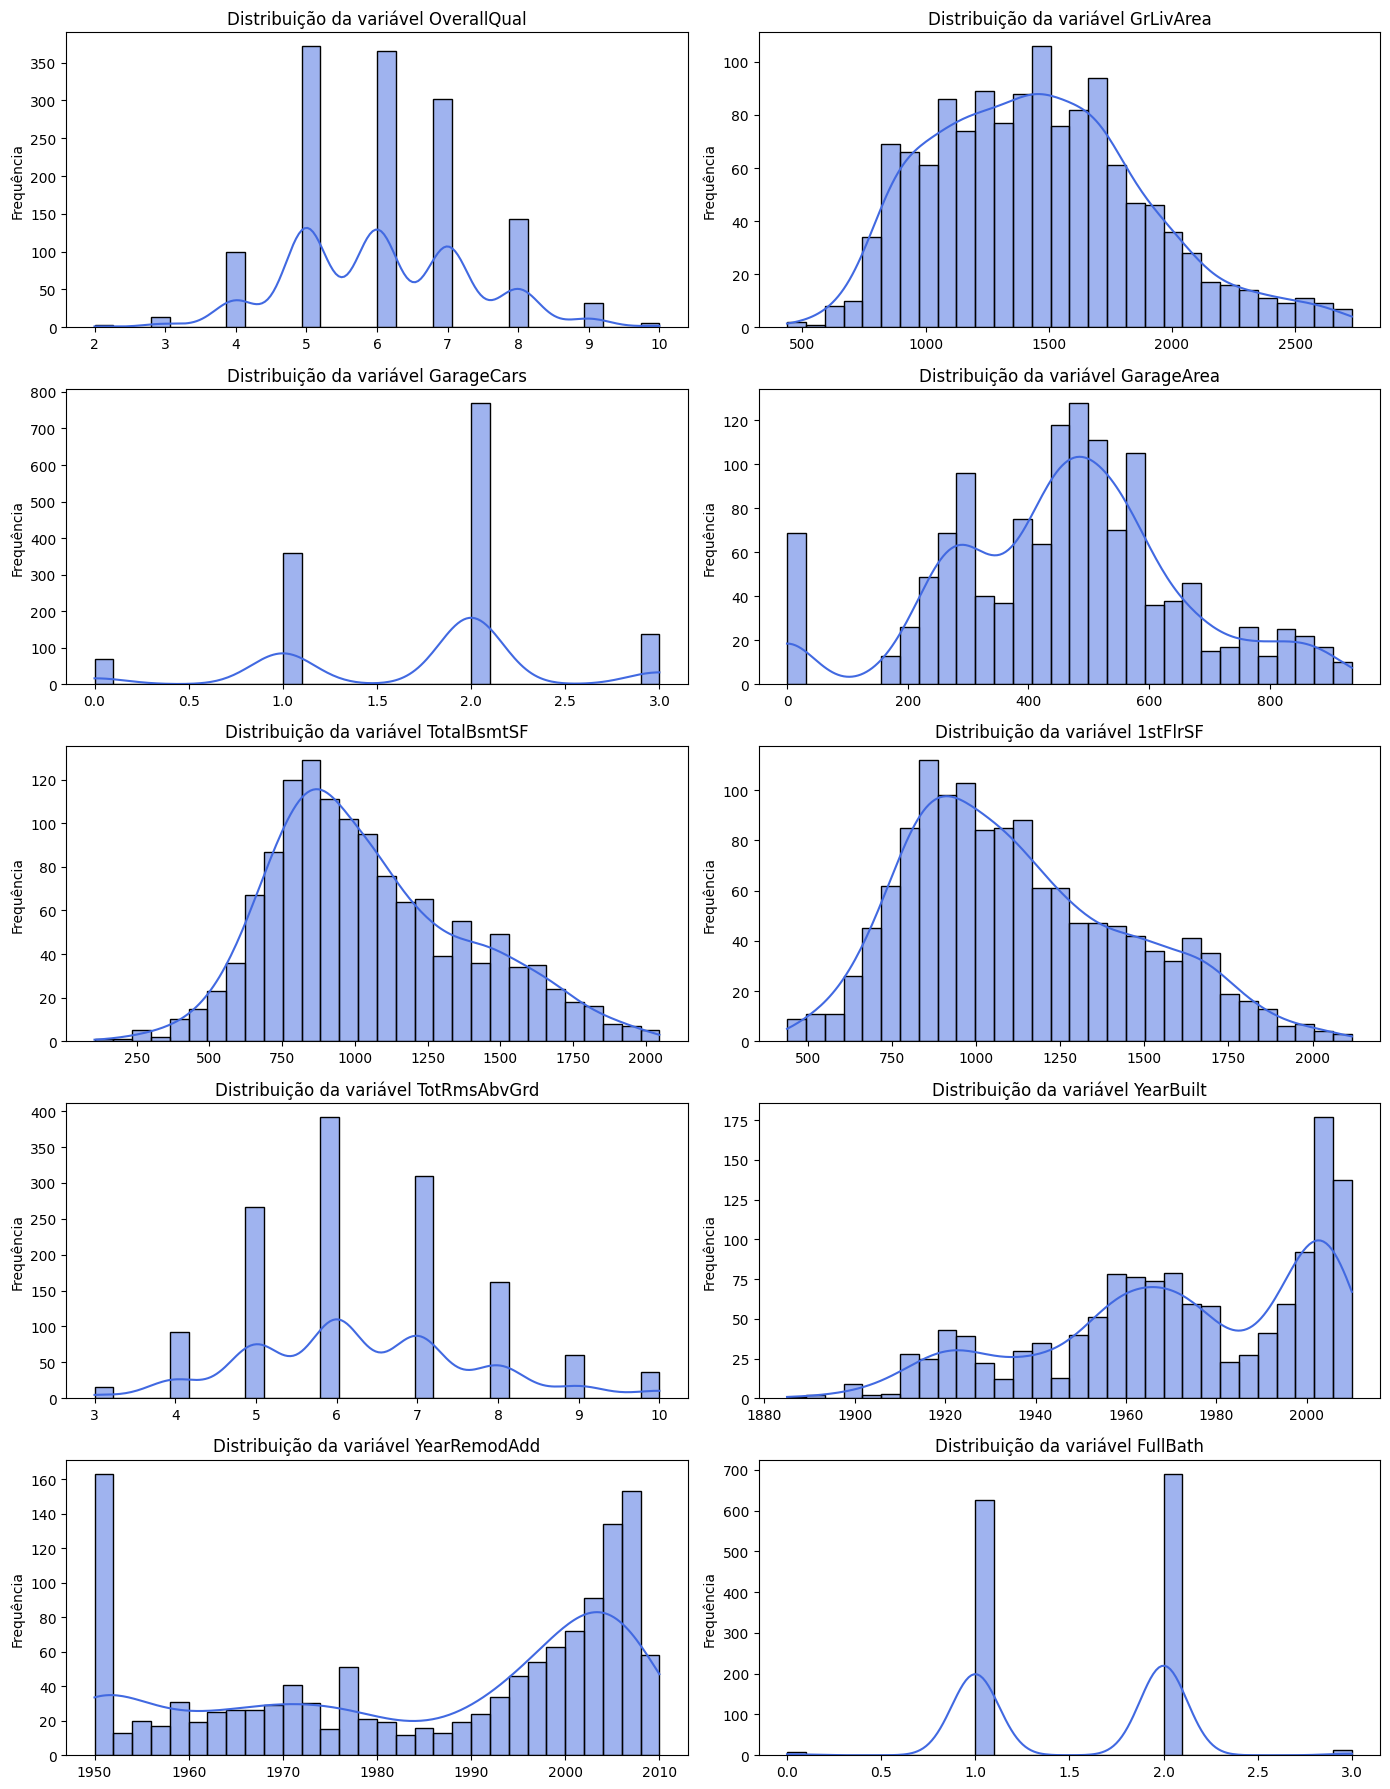

In [16]:
# Definir as colunas a serem analisadas
columns_to_analyze = [
    "OverallQual", "GrLivArea", "GarageCars", "GarageArea", 
    "TotalBsmtSF", "1stFlrSF", "TotRmsAbvGrd", 
    "YearBuilt", "YearRemodAdd", "FullBath"
]

# Criar gráficos de distribuição
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 18))
axes = axes.flatten()

for i, col in enumerate(columns_to_analyze):
    sns.histplot(df_filtered[col], bins=30, kde=True, ax=axes[i], color="royalblue")
    axes[i].set_title(f"Distribuição da variável {col}", fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequência")

plt.tight_layout()
plt.show()

#### 2.1. Padronização das Variáveis

Em seguida, aplicamos a padronização (StandardScaler) nas variáveis escolhidas, ajustando os dados para que cada variável tenha média zero e desvio padrão igual a um. Essa técnica é essencial para algoritmos como a Regressão Linear, pois evita que variáveis com diferentes escalas influenciem de forma desproporcional o modelo.

Com isso, garantimos que todas as variáveis estejam na mesma escala e que os outliers não comprometam a performance do algoritmo de regressão.

In [17]:
# Colunas que serão padronizadas
colunas_para_padronizar = ["GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "TotRmsAbvGrd"]

# Instanciar o StandardScaler
scaler = StandardScaler()

# Aplicar a transformação
df_filtered[colunas_para_padronizar] = scaler.fit_transform(df_filtered[colunas_para_padronizar])

In [18]:
df_filtered[colunas_para_padronizar].head()

,GrLivArea,GarageArea,TotalBsmtSF,1stFlrSF,TotRmsAbvGrd
0,0.595659,0.450662,-0.562369,-0.812262,1.161247
1,-0.449671,0.000590,0.626510,0.414028,-0.242978
2,0.772991,0.757529,-0.374960,-0.618955,-0.242978
3,0.611992,0.931420,-0.855197,-0.495118,0.459134
4,1.734321,1.923624,0.283902,0.060639,1.863360


#### Conclusão da Análise de Distribuição das Variáveis
A análise da distribuição das variáveis revelou que algumas possuem uma assimetria significativa, enquanto outras seguem uma distribuição mais equilibrada. Com base nessa avaliação, foram feitas as seguintes decisões:

##### Variáveis que foram normalizadas:
- **GrLivArea**, **GarageArea**, **TotalBsmtSF**, **1stFlrSF** e **TotRmsAbvGrd** apresentam distribuições enviesadas à direita, com valores extremos influenciando a média. Para essas variáveis, será aplicada uma **transformação logarítmica** ou de **raiz quadrada**, dependendo do grau de assimetria. A escolha se baseia no fato de que essas transformações reduzem a dispersão dos dados e aproximam a distribuição da normal.

##### Variáveis que foram mantidas sem normalização:
- **OverallQual** e **GarageCars** são variáveis discretas e categóricas ordinais, onde a normalização não se aplica.

- **YearBuilt** e **YearRemodAdd** serão transformadas em "idade do imóvel" (2025 - YearBuilt) e "tempo desde a última reforma" (2025 - YearRemodAdd), pois faz mais sentido trabalhar com o tempo decorrido em vez do ano absoluto.

- **FullBath** possui poucos valores distintos e não há necessidade de normalização.

### 3. Preparação Final dos Dados para o Modelo de Regressão

#### 3.1 Separação entre Variáveis Preditivas e Variável Alvo
Para treinar um modelo de regressão, é essencial separar a variável alvo (SalePrice) das variáveis preditoras. A variável alvo representa o que se deseja prever — neste caso, o preço final da casa — enquanto as variáveis preditoras são as características do imóvel que influenciam esse valor.

In [19]:
# Separar variável alvo e variáveis preditoras
y = df_filtered["SalePrice"]               # Variável alvo
X = df_filtered.drop("SalePrice", axis=1) # Variáveis preditoras

#### 3.2 Divisão entre Treino e Teste
Embora essa separação normalmente seja feita utilizando train_test_split para dividir o dataset em subconjuntos de treino e teste (como 80%/20%), no contexto atual o conjunto de dados já foi previamente dividido. Portanto, essa etapa não será repetida.

In [20]:
# Dividir em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Conclusão da Engenharia de atributos**
Após uma série de etapas: incluindo análise e tratamento de outliers, transformação e padronização de variáveis. Concluí a preparação do conjunto de dados. A variável alvo foi devidamente separada das preditoras, e a divisão entre treino e teste já está definida. Com isso, os dados estão prontos para o início do treinamento do modelo de regressão linear, garantindo uma base sólida e consistente para a construção de previsões confiáveis.

## Treinamento e Avaliação

Com os dados prontos, iniciamos agora o processo de construção e treinamento do modelo de regressão linear. Esta etapa é para que o modelo aprenda os padrões presentes nos dados e seja capaz de realizar previsões com boa acurácia. Utilizaremos os dados de treino (80% do total) para ajustar o modelo, e posteriormente avaliaremos seu desempenho utilizando os dados de teste, garantindo que a análise seja confiável e generalizável.

### Treinamento

In [21]:
# Instancia do modelo
modelo = LinearRegression()

# Treinamento
modelo.fit(X_train, y_train)

# Predição
y_pred = modelo.predict(X_test)

Para a visualização do treinamento do modelo, coloquei o gráfico de resíduos para verificar a qualidade das previsões e identificar possíveis problemas no modelo. Se os resíduos forem distribuídos aleatoriamente em torno de zero, isso indica que o modelo está bem ajustado. No entanto, se houver tendências ou agrupamentos, isso sugere que o modelo pode não estar conseguindo capturar toda a variabilidade dos dados, e ajustes adicionais seriam necessários. Esse gráfico também facilita a identificação de pontos influentes que podem distorcer os resultados, ajudando a tomar decisões sobre a necessidade de tratar ou remover esses valores atípicos. Portanto, a visualização dos resíduos é uma ferramenta essencial para garantir que o modelo esteja bem calibrado e adequado para as previsões.

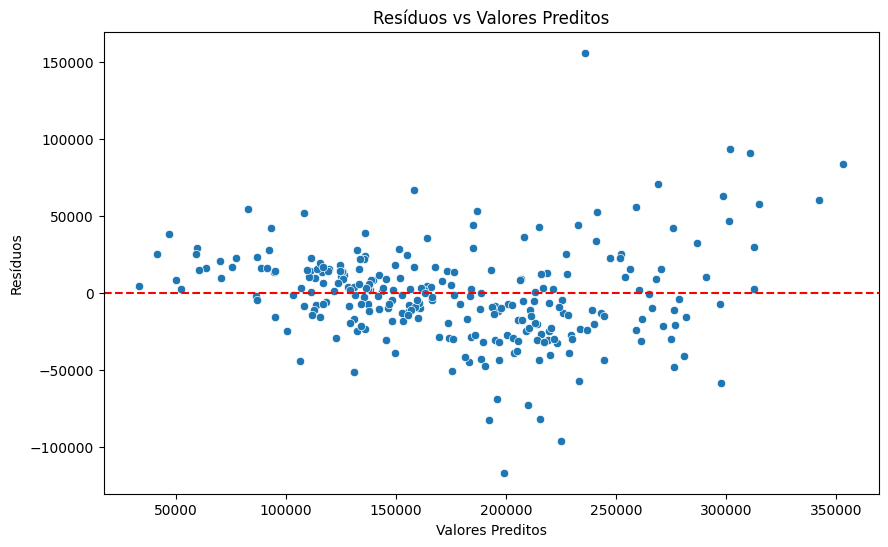

In [22]:
# Cálculo dos resíduos
residuos = y_test - y_pred

# Gráfico de dispersão dos resíduos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Valores Preditos")
plt.show()

### Avaliação

#### R² (Coeficiente de Determinação):
O R² é utilizada para avaliar a qualidade do ajuste de um modelo de regressão. Ele indica a proporção da variabilidade dos dados que é explicada pelo modelo. Um valor de R² próximo de 1 sugere que o modelo consegue explicar a maior parte da variação dos dados, o que indica um bom desempenho. Por outro lado, um R² muito baixo significa que o modelo não está conseguindo capturar bem a relação entre as variáveis. 

In [23]:
print("R²:", r2_score(y_test, y_pred))

R²: 0.8003212502235761


#### RMSE (Root Mean Squared Error):
O RMSE é uma métrica que mede a diferença média entre os valores reais e os valores previstos pelo modelo, penalizando mais fortemente os grandes erros. A principal vantagem do RMSE é que ele expressa o erro na mesma unidade da variável alvo, o que facilita a interpretação. Por exemplo, neste modelo de previsão de preços de casas, o RMSE indicará o erro médio em termos de unidade monetária. Quanto menor o valor do RMSE, melhor será o desempenho do modelo, já que ele indica que as previsões estão mais próximas dos valores reais.

print("RMSE:", mean_squared_error(y_test, y_pred))

#### MAE (Mean Absolute Error):
O MAE é uma métrica simples que calcula a média das diferenças absolutas entre os valores reais e os valores previstos, sem penalizar os grandes erros de forma tão acentuada quanto o RMSE. Ele fornece uma ideia clara do erro médio, sem influências de outliers, já que não eleva as diferenças ao quadrado. O MAE é útil quando se quer entender o erro médio de forma direta e não precisa de um valor tão sensível a grandes discrepâncias. Assim como o RMSE, quanto menor o MAE, melhor será a performance do modelo, mas o MAE pode ser mais fácil de interpretar, já que trata os erros de maneira uniforme.

In [24]:
print("MAE:", mean_absolute_error(y_test, y_pred))

MAE: 22095.239309973676


### Conclusão da Avaliação
Com base nos resultados obtidos, podemos observar que o **R²** apresenta um valor de **0.80**, o que indica que o modelo está explicando aproximadamente 80% da variabilidade dos dados, o que é um bom indicativo de desempenho.

No entanto, o **RMSE** extremamente elevado, de cerca de **931 milhões**, sugere a presença de grandes erros nas previsões, o que é sinal de que o modelo pode estar sendo impactado por outliers ou por dados atípicos que estão distorcendo as previsões. 

O **MAE** de aproximadamente 22 mil indica que, em média, o modelo está errando por esse valor nas suas previsões. Embora esse número possa parecer alto em alguns contextos, para a previsão do preço de uma casa, ele não é tão ruim. Isso ocorre porque os preços de casas geralmente variam em valores muito maiores, e um erro de **22 mil** pode ser considerado uma margem aceitável em muitos casos, especialmente se o valor total da casa for muito maior. Portanto, o MAE nesse cenário pode ser visto como uma indicação de que o modelo está fazendo previsões razoavelmente precisas, dado o contexto do mercado imobiliário, embora sempre seja possível buscar melhorias.

Na próxima versão do modelo, é importante realizar uma análise mais profunda e limpeza dos dados, especialmente no que diz respeito aos outliers e normalização, para garantir que eles não comprometam o desempenho do modelo e melhorem a precisão das previsões.

## Conclusão

Este projeto foi uma jornada de aprendizado incrível, onde tive a oportunidade de aplicar e aprofundar meus conhecimentos sobre machine learning, modelagem de dados e análise de performance. Ao longo do processo, aprendi não só sobre tecnicas de limpeza, treinamento e avaliacao, mas também sobre a importância de transmitir a mensagem de forma clara e entendível sobre cada etapa do pipeline de dados . 

A experiência de ver como as previsões do modelo se alinham com os resultados reais, e refletir sobre as métricas e os erros, trouxe uma compreensão mais profunda sobre a complexidade envolvida na construção de modelos . 

A jornada também reforçou a importância da limpeza e preparação dos dados, especialmente no que diz respeito aos outliers e à normalização, áreas que pretendo explorar mais a fundo nas próximas versões do modelo. 

No final, esse projeto não só me ajudou a aprimorar minhas habilidades técnicas, mas também me fez entender a importância de olhar para os dados e para os resultados com uma perspectiva crítica e prática. Agradeço por ter acompanhado ate aqui e por todo o aprendizado que esse projeto me proporcionou.